<a href="https://colab.research.google.com/github/haooooooqi/visualization/blob/main/video_mae_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install opencv3
    !pip3 install simplejson
    !pip3 install matplotlib
    !pip3 install iopath
    !pip install common
    !pip install fvcore
    !pip install av
    !rm -rf visualization mae
    !git clone https://github.com/haooooooqi/visualization.git
    !mv visualization mae
    sys.path.append('./mae')
    !rm -rf slowfast SlowFast
    !git clone https://github.com/facebookresearch/SlowFast.git
    !mv SlowFast slowfast
    sys.path.append('./slowfast')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     |████████████████████████████████| 287 kB 20.5 MB/s 
ERROR: Could not find a version that satisfies the requirement opencv3 (from versions: none)
ERROR: No matching distribution found for opencv3
     |████████████████████████████████| 130 kB 12.4 MB/s 
  Created wheel for common: filename=common-0.1.2-py3-none-any.whl size=3732 sha256=ccddfe2c1d833dbb84e5afef96a9367040466252c7546c30d6b6ecadb7cbb443
  Stored in directory: /root/.cache/pip/wheels/11/88/ea/416ddc295a285f3661c88772a64b4a3766a92ce55f7b01dd9d
Successfully built common
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220414-py3-none-any.whl size=61211 sha256=a14f37c1ae07632bc33e3fb4cc19c673218ec06462877f733f229055f5dc6ec5
  Stored in directory: /root/.cache/pip/wheels/df/f4/b8/7b5df8b6722f4c72315ce70c31aa693e00cef6a5056149bd28
Successfully built fvcore
  Attempting uninstall: pyyaml


### Define utils

In [45]:
from slowfast.datasets.decoder import pyav_decode, temporal_sampling
from mae.util.decoder.utils import tensor_normalize, spatial_sampling


MEAN = (0.45, 0.45, 0.45)
STD = (0.225, 0.225, 0.225)
DEMO_PATH = "mae/demo/qZ_lFjCiR1c_000104_000114.avi"

def prepare_video(path):
    video_container = av.open(path)
    frames, _, _ = pyav_decode(
        video_container,
        4,
        16,
        5,
        num_clips_uniform=10,
        target_fps=30,
        use_offset=False,
    )
    frames = temporal_sampling(frames, 0, 64, 16)
    frames = tensor_normalize(
        frames, 
        torch.tensor(MEAN), 
        torch.tensor(STD),
    ).permute(3, 0, 1, 2)
    frames = spatial_sampling(
        frames,
        spatial_idx=1,
        min_scale=256,
        max_scale=256,
        crop_size=224,
        random_horizontal_flip=False,
        inverse_uniform_sampling=False,
    )
    frames = spatial_sampling(
        frames,
        spatial_idx=1,
        min_scale=256,
        max_scale=256,
        crop_size=224,
        random_horizontal_flip=False,
        inverse_uniform_sampling=False,
        aspect_ratio=None,
        scale=None,
        motion_shift=False,
    )
    return frames

In [46]:
vid = prepare_video(DEMO_PATH)

In [92]:
def plot_input(tensor):
    tensor = tensor.float()
    f, ax = plt.subplots(nrows=tensor.shape[0], ncols=tensor.shape[1], figsize=(50, 20))

    tensor = tensor * torch.tensor(STD).view(3, 1, 1)
    tensor = tensor + torch.tensor(MEAN).view(3, 1, 1)
    tensor = torch.clip(tensor * 255, 0, 255).int()

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax[i][j].axis("off")
            ax[i][j].imshow(tensor[i][j].permute(1, 2, 0))
    plt.show()

In [98]:
from mae.models_mae import mae_vit_large_patch16
model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st")

img_size (224, 224) patch_size (16, 16) frames 16 t_patch_size 4
==== num_patches 784
model initialized


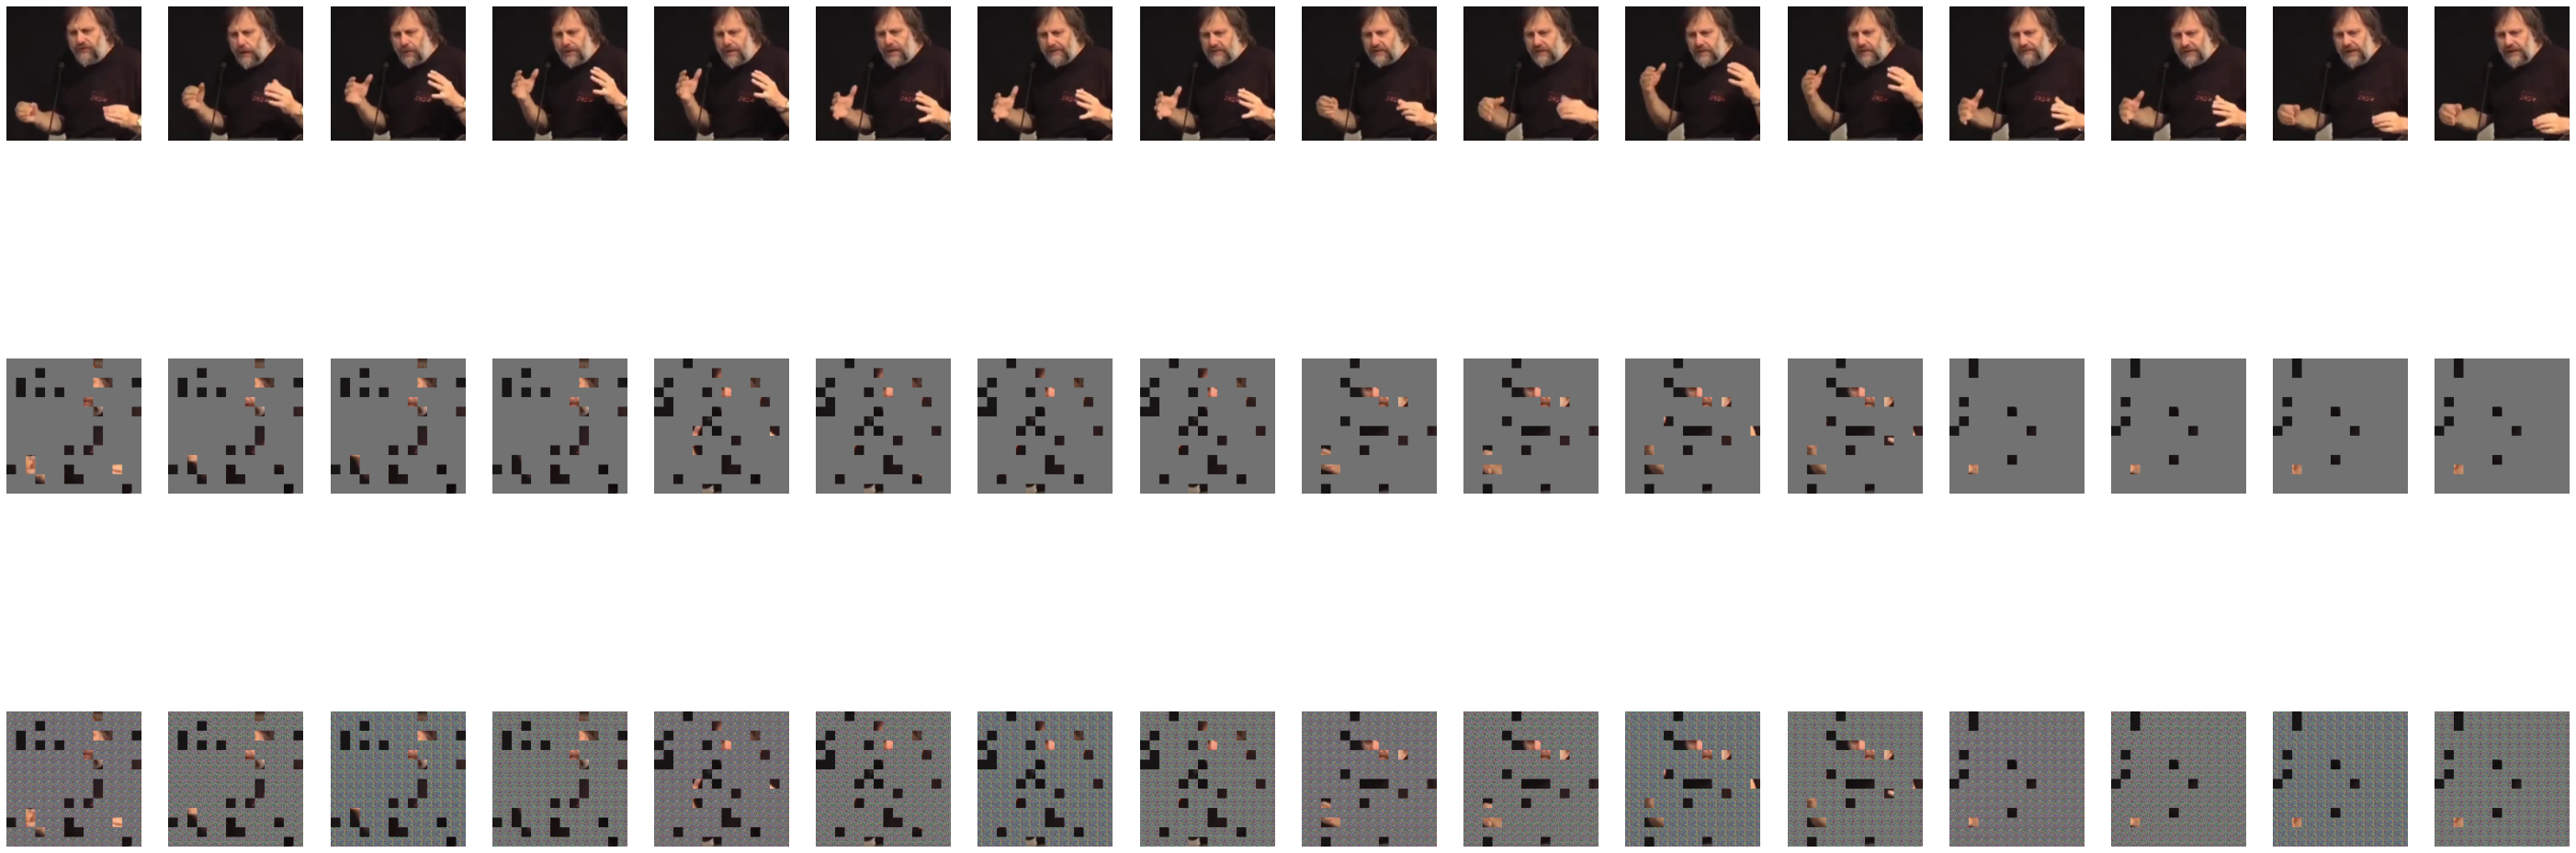

In [109]:
_, _, _, vis = model(vid.unsqueeze(0), 1, mask_ratio=0.9, visualize=True)
plot_input(vis[0].permute(0, 2, 1, 3, 4))